# Ensembling

TODO: elaborate

## Google Colab

The first cell will only be run in Google Colab, the second one locally as well.

In [1]:
import sys

IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    # noinspection PyUnresolvedReferences
    from google.colab import drive

    drive.mount('/content/drive')

In [2]:
import os
import glob


# let's keep this cell at the beginning for every notebook
# for more convenient training in Google Colab
def get_root_path(filename: str) -> str:
    """Get root path based on notebook's name."""
    filepath = glob.glob(os.getcwd() + '/**/' + filename, recursive=True)[0]
    return os.path.dirname(os.path.dirname(filepath))


ROOT_PATH = get_root_path('ensembling.ipynb')
sys.path.append(ROOT_PATH)

# go to the drive directory
os.chdir(ROOT_PATH) if IN_COLAB else None

## Imports

In [3]:
import os
import cv2
import torch

import albumentations as A
import segmentation_models_pytorch as smp

from sklearn.model_selection import KFold
from scripts.evaluation import EvaluationMonitor, Ensembler
from scripts.preprocessing import RoadDataset, split_data
from scripts.training import setup_seed, valid_epoch, train_epoch
from torch.utils.data import DataLoader, SubsetRandomSampler
from torch.optim.lr_scheduler import CosineAnnealingLR

In [4]:
# necessary for downloading some of the models
import ssl

ssl._create_default_https_context = ssl._create_unverified_context

In [5]:
setup_seed(16)

## Data

In [6]:
# specify train directory
train_directory = os.path.join(ROOT_PATH, 'data', 'raw', 'train')

In [7]:
# image paths so that all the images are used for train dataset (no test set for cv due to small training set)
image_path_train, _, mask_path_train, _ = split_data(train_directory, test_size=0)

# create train Dataset without transformations for now
train_dataset = RoadDataset(image_path_train, mask_path_train)

In [8]:
# define transformations
train_tf = A.Compose([
    A.Resize(height=608, width=608, always_apply=True),
    A.Rotate(p=0.5, limit=180, border_mode=cv2.BORDER_CONSTANT, rotate_method="ellipse"),
    A.RandomBrightnessContrast(p=0.5)
])

valid_tf = A.Compose([A.Resize(height=608, width=608, always_apply=True)])

## Hyperparameters

Since our aim is to see, how different architectures influence the training, we fix the model, epochs and batch sizes.

In [9]:
ENCODER_WEIGHTS = 'imagenet'

SEED = 16
BATCH_SIZE = 4
K_FOLD = 3
N_CPU = os.cpu_count()
N_EPOCHS = 50
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

LOADER_PARAMS = {
    'batch_size': BATCH_SIZE
}

## Encode-Decoder Combinations

In [10]:
# specify the root path for evaluation json-s
encoder_decoder = [
    ('inceptionv4', 'UnetPlusPlus'),
    ('mit_b2', 'Unet'),
    ('efficientnet-b4', 'UnetPlusPlus')
]

## Cross-Validation

In [13]:
eval_monitor = EvaluationMonitor(os.path.join(ROOT_PATH, 'data', 'results', 'ensembling'))

In [ ]:
k_fold = KFold(n_splits=K_FOLD, shuffle=True, random_state=SEED)

# Get training and validation indices
for fold, (train_idx, val_idx) in enumerate(k_fold.split(train_dataset)):

    # Create training and validation loaders by providing current K-Fold train/validation indices to Sampler
    train_loader = DataLoader(
        train_dataset.set_tf(train_tf), sampler=SubsetRandomSampler(train_idx), **LOADER_PARAMS
    )

    valid_loader = DataLoader(
        train_dataset.set_tf(valid_tf), sampler=SubsetRandomSampler(val_idx), **LOADER_PARAMS
    )

    models = [
        smp.create_model(
            decoder, encoder_name=encoder, encoder_weights=ENCODER_WEIGHTS
        ).to(DEVICE) for encoder, decoder in encoder_decoder
    ]

    optimizers = [torch.optim.Adam(model_.parameters(), lr=0.0005) for model_ in models]
    # TODO add comment
    t_max = (len(train_loader.dataset) * N_EPOCHS) // train_loader.batch_size
    schedulers = [CosineAnnealingLR(optimizer_, T_max=t_max, ) for optimizer_ in optimizers]
    criterion_ = smp.losses.DiceLoss(smp.losses.BINARY_MODE, from_logits=True)

    zipped_values = [encoder_decoder, models, optimizers, schedulers]

    for i in range(N_EPOCHS):

        ensembler = Ensembler()

        # since we want to have the same transformations for every model
        train_data = [(image, mask) for image, mask in train_loader]
        valid_data = [(image, mask) for image, mask in valid_loader]

        for (enc, dec), model_, opt_, sched_ in zip(*zipped_values):
            ensembler.set_model(enc, dec)

            _, train_f1 = train_epoch(
                model_, train_data, criterion_, opt_, sched_, i + 1, ensembler=ensembler
            )
            _, valid_f1 = valid_epoch(
                model_, valid_data, criterion_, i + 1, ensembler=ensembler
            )

            eval_monitor.update_metrics_by_fold(
                setup='+'.join([enc, dec]),
                fold=fold,
                training_f1=train_f1,
                validation_f1=valid_f1
            )

        # meta learner
        eval_monitor.update_metrics_by_fold(
            setup='ensembling',
            fold=fold,
            training_f1=ensembler.get_f1('training'),
            validation_f1=ensembler.get_f1('validation')
        )

    eval_monitor.update_jsons()

## Ensembling

CV was run on colab, the predictions saved to JSON, and now we can apply ensembling.

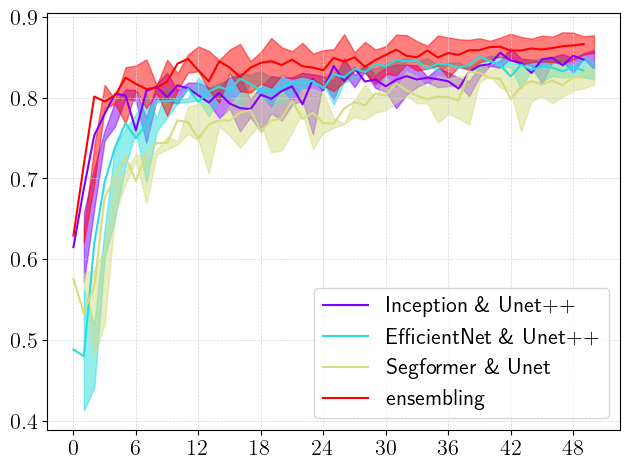

In [23]:
import numpy as np
from scripts.plotting import plot_cv_per_epoch

cv_val = eval_monitor.data['validation_f1']

cv_data = {
    r'Inception \& Unet++': np.array(cv_val[('inceptionv4', 'UnetPlusPlus')]),
    r'EfficientNet \& Unet++': np.array(cv_val[('efficientnet-b4', 'UnetPlusPlus')]),
    r'Segformer \& Unet': np.array(cv_val[('mit_b2', 'Unet')]),
    r'ensembling': np.array(cv_val[('ensembling',)])
}

plot_cv_per_epoch(
    y_label='',
    title='',
    is_std=True,
    **cv_data
)